# **Imports**
Necessary imports and installs.

In [5]:
# !pip install ipywidgets
!pip install datasets

import json
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from pandas import DataFrame
from collections import defaultdict
import re
import numpy as  np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from huggingface_hub import login
from datasets import load_dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Upload datasets**
The datasets are downloaded from HuggingFace.

In [9]:
xnlieu = load_dataset("HiTZ/xnli-eu", "eu")
xnlieumt = load_dataset("HiTZ/xnli-eu", "eu_mt")
native = load_dataset("HiTZ/xnli-eu", "eu_native")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

A random split is selected: the test set of XNLIeu.

In [15]:
xnlieu_test = pd.DataFrame(xnlieu["test"])

In [16]:
xnlieu_test

,premise,hypothesis,label
0,"Beno, horretan pentsatzen ere ez nintzen ari, ...",Ez dut berriz harekin hitz egin.,contradiction
1,"Beno, horretan pentsatzen ere ez nintzen ari, ...","Hain nengoen haserre, ezen berriro hasi nintze...",entailment
2,"Beno, horretan pentsatzen ere ez nintzen ari, ...",Solasaldi ederra izan genuen.,neutral
3,"Eta pentsatu nuen hori pribilegio bat zela, et...",Ez nekien egun hartan ez nintzenla landan zego...,neutral
4,"Eta pentsatu nuen hori pribilegio bat zela, et...",AFSC Aireko Indarraren Karrera alorrean zenbak...,entailment
...,...,...,...
5005,Davidsonek ez luke «scone» hitza ahoskatu beha...,Davidsonek ez luke hitz egin behar «scone» eta...,entailment
5006,Davidsonek ez luke «scone» hitza ahoskatu beha...,Hobe litzateke Davidsonen hizkeran «scone» eta...,contradiction
5007,25 dolarreko batez besteko eleberri bat (200.0...,200.000 hitzeko eleberri bat 25 dolar ordaintz...,neutral
5008,25 dolarreko batez besteko eleberri bat (200.0...,200.000 hitzeko eleberri batek 25 dolar balio ...,contradiction


# **Functions**
Two functions are used to inspect the dataset: to obtain statistics about the number of tokens and the cosine similarity between premise and hypothesis.

In [29]:
def length(df):

    def count_tokens(sent):
      tokens = nltk.word_tokenize(sent)
      return len(tokens)

    df["sen1_len"] = df['premise'].apply(count_tokens)
    df["sen2_len"] = df['premise'].apply(count_tokens)

    sum_length = {"neutral":0,"contradiction":0,"entailment":0}
    list_length = {"neutral":[],"contradiction":[],"entailment":[]}
    for index, row in df.iterrows():
        temp_len = int(row["sen1_len"])
        sum_length[row["label"]] += temp_len
        list_length[row["label"]].append(temp_len)
    print("Total average " + str(df["sen2_len"].mean()))

    for label in sum_length:
        avg = df[df['label']==label]["sen2_len"].mean()
        list_length[label].sort()
        median = list_length[label][round(len(list_length[label])/2)]
        print(label)
        print("Median number of tokens: "+ str(median))
        print("Average number of tokens: "+ str(avg))
        print("-"*50)


In [32]:
def calc_cosine(df):

    def cosine(text1,text2):
      vectorizer = TfidfVectorizer()
      vectors = vectorizer.fit_transform([text1, text2])

      # Calculate the cosine similarity between the vectors
      similarity = cosine_similarity(vectors)
      return similarity[0][1]

    dict_dif = {"neutral":[],"contradiction":[],"entailment":[]}
    for label in list(df.label.unique()):
        max_cos = {"value":0,"sen1":"","sen2":""}
        differences = []
        for index, row in df.iterrows():
          if row["label"] == label:
              cos = cosine(row["premise"],row["hypothesis"])
              if cos > max_cos["value"]:
                  max_cos = {"value":cos,"sen1":row["premise"],"sen2":row["hypothesis"]}
              differences.append(cos)
        print(label)
        print("mean:")
        print(sum(differences)/len(differences))
        differences.sort()
        median = differences[round(len(differences)/2)]
        print("median:")
        print(median)
        print("max cos:")
        print(max_cos)
        print("-"*50)
        dict_dif[label] = differences

    # Creating dataset
    plt.rc('ytick',labelsize=25)
    plt.rc('xtick',labelsize=25)
    fig = plt.figure(figsize =(10, 7))
    data = [dict_dif["entailment"],dict_dif["contradiction"],dict_dif["neutral"]]
    # Creating plot
    plt.boxplot(data, labels = ["entailment","contradiction","neutral"],showfliers = False)

## Examples
The functions are used with the test split of XNLIeu. They could be applied to any split and subset.

In [30]:
length(xnlieu_test)

Total average 17.069461077844313
neutral
Median number of tokens: 16
Average number of tokens: 17.069461077844313
--------------------------------------------------
contradiction
Median number of tokens: 16
Average number of tokens: 17.069461077844313
--------------------------------------------------
entailment
Median number of tokens: 16
Average number of tokens: 17.069461077844313
--------------------------------------------------


contradiction
mean:
0.12372964475448697
median:
0.09349477497536716
max cos:
{'value': 0.9138106509294462, 'sen1': 'Suediako Eliza eta Suediar Eliza ez dira gauza bera.', 'sen2': 'Suediako Eliza eta Suediar Eliza gauza bera dira.'}
--------------------------------------------------
entailment
mean:
0.19615174800267063
median:
0.15976420924144444
max cos:
{'value': 1.0000000000000004, 'sen1': 'Orain ere, Bloodek ez zion jaramonik egiten.', 'sen2': 'Orain ere, Bloodek ez zion jaramonik egiten.'}
--------------------------------------------------
neutral
mean:
0.1162291150593796
median:
0.08704446792504217
max cos:
{'value': 1.0000000000000002, 'sen1': 'Gora eta behera korrika egitea.', 'sen2': 'Gora eta behera korrika egitea.'}
--------------------------------------------------


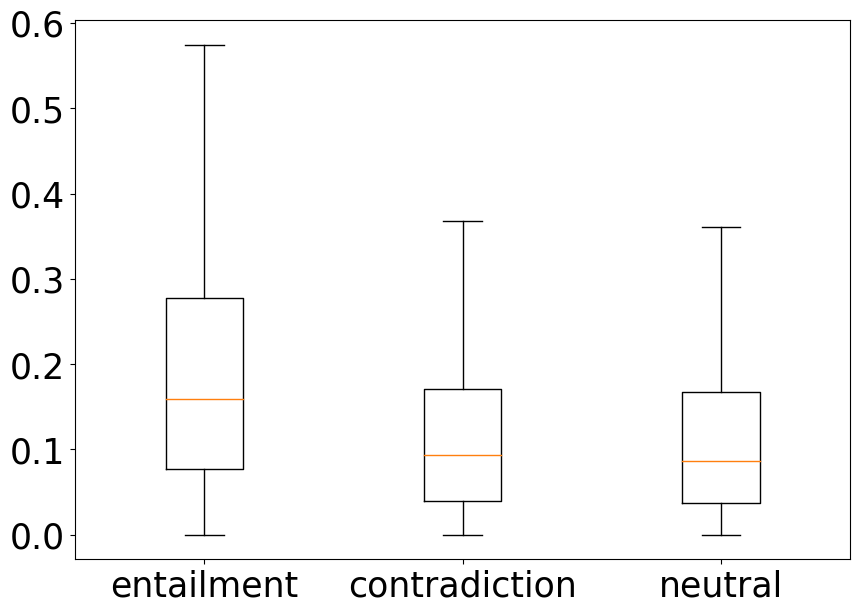

In [33]:
calc_cosine(xnlieu_test)